# Experiments with Similaritiy Encoders
In this iPython Notebook are some examples to illustrate the potential of Similarity Encoders (SimEc) for creating similarity preserving embeddings. For further details and theoretical background on this new neural network architecture, please see the corresponding paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, squareform
import theano.tensor as T
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.manifold import Isomap, TSNE
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import load_digits, fetch_mldata, fetch_20newsgroups

# find nlputils at https://github.com/cod3licious/nlputils
from nlputils.features import FeatureTransform, features2mat

from utils import load_dataset, plot2d, plot3d, plot_digits, plot_mnist, plot_20news
from similarity_encoder import SimilarityEncoder, center_K, thr_sigmoid

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Toy Dataset 3 Circles
Sanity check on an artifically generated toy dataset: Linear similarity encoders reach the same solution as PCA/linear kPCA (up to a rotation and scaling) and nicely map the test examples where they belong.

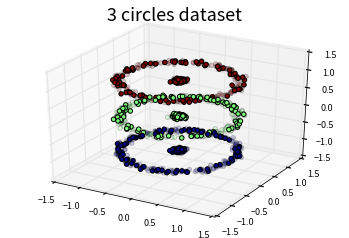

In [2]:
n_train = 1000
n_test = 500
dataset = '3_circles'
# get training and test data
X, Y_plot = load_dataset(dataset, n_train, 3)
X_test, Y_plot_test = load_dataset(dataset, n_test, 5)
# plot the original data
plot3d(X, Y_plot, X_test, Y_plot_test, title='%s dataset' % dataset.replace('_', ' '))

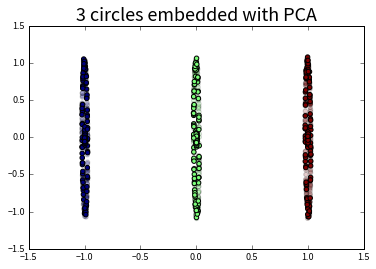

In [3]:
# simple 2d PCA solution
e_pca = PCA(n_components=2)
X_embed = e_pca.fit_transform(X)
X_embed_test = e_pca.transform(X_test)
plot2d(X_embed, Y_plot, X_embed_test, Y_plot_test, title='%s embedded with PCA' % dataset.replace('_', ' '))

Final training error: 0.0124266271; lowest error: 0.0124266271
Last mean error: 0.0124263179


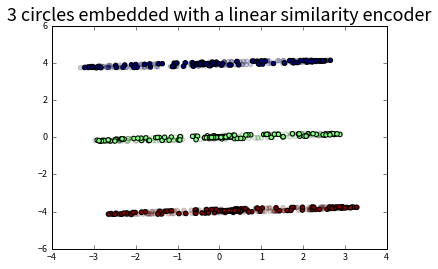

In [4]:
# similarity encoder no activation function, linear similarity function
K_lin = np.dot(X, X.T)
e_lsimenc = SimilarityEncoder(K_lin.shape[1], X.shape[1], e_dim=2)
e_lsimenc.fit(X, K_lin, verbose=False)
X_embed = e_lsimenc.transform(X)
X_embed_test = e_lsimenc.transform(X_test)
plot2d(X_embed, Y_plot, X_embed_test, Y_plot_test, title='%s embedded with a linear similarity encoder' % dataset.replace('_', ' '))

### Handwritten Digits (8x8 px)
See `http://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html`

In [5]:
# load digits dataset
digits = load_digits()
X = digits.data
X /= float(X.max())
y = digits.target
n_samples, n_features = X.shape

#### Sanity Check: linear kernel PCA
a linear SimEc gets the same solution as PCA (= linear kernel PCA) up to a rotation

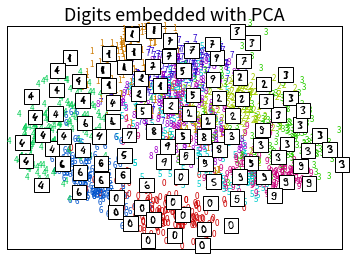

In [6]:
# PCA
e_pca = PCA(n_components=2)
X_embed = e_pca.fit_transform(X)
plot_digits(X_embed, digits, title='Digits embedded with PCA')

Final training error: 0.0097277279; lowest error: 0.0097277279
Last mean error: 0.0097273537


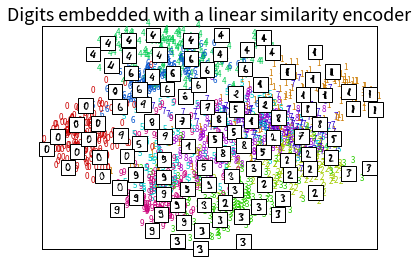

In [7]:
# linear similarity encoder (center the kernel matrix first!)
K_lin = np.dot(X, X.T)
e_lsimenc = SimilarityEncoder(K_lin.shape[1], X.shape[1], e_dim=2)
e_lsimenc.fit(X, center_K(K_lin), verbose=False)
X_embed = e_lsimenc.transform(X)
plot_digits(X_embed, digits, title='Digits embedded with a linear similarity encoder')

#### t-SNE
A visualization like that created with t-SNE might look better. (But do you notice those few examples trapped between the clusters? This happens because the embedding coordinates are optimized directly instead of learning a mapping function.)

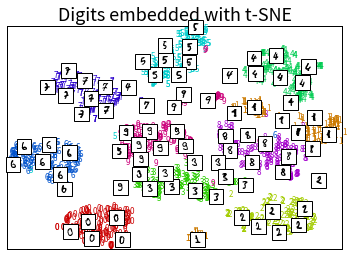

In [8]:
# t-SNE
e_tsne = TSNE(n_components=2, random_state=1, method='exact')
X_embed = e_tsne.fit_transform(X)
plot_digits(X_embed, digits, title='Digits embedded with t-SNE')

#### SimEc based on class labels
We can construct the similarity matrix from the class labels (1=same class, 0=different class). Since our labels are between 0 and 1 we use in the last layer a sigmoid function to threshold the output. Between 0 and 1 the output is mapped approximately linearly to the interval [0, 1], higher or lower the values are thresholded.

We try a linear SimEc, one with one hidden layer (with a tanh activation function) and one with two hidden layers. We observe that the clusters move further and further apart and in the case with two hidden layers the classes are nicely separated in tight clusers.

In [9]:
Y = np.tile(y, (len(y), 1))
S = np.array(Y==Y.T, dtype=int)

Final training error: 0.0586172779; lowest error: 0.0585209403
Last mean error: 0.0586356833


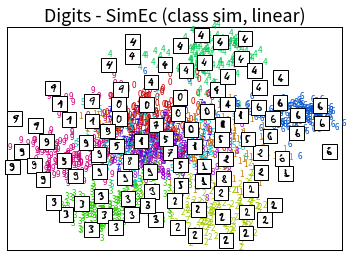

In [10]:
# similarity encoder with similarities relying on class information - linear
# no centering of S but instead a thresholding in the last layer to transform the output to be between 0 and 1
e_csimenc = SimilarityEncoder(S.shape[1], X.shape[1], 2, [], [None, thr_sigmoid], lrate=5., orthOT_reg=0.1)
e_csimenc.fit(X, S, verbose=False)
X_embed = e_csimenc.transform(X)
plot_digits(X_embed, digits, title='Digits - SimEc (class sim, linear)')

Final training error: 0.0511026480; lowest error: 0.0506610042
Last mean error: 0.0527081749


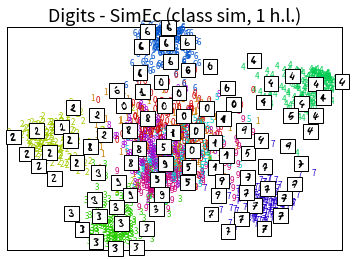

In [11]:
# similarity encoder with similarities relying on class information - 1 hidden layer
e_csimenc = SimilarityEncoder(S.shape[1], X.shape[1], 2, [100], [T.tanh, None, thr_sigmoid], lrate=5., orthOT_reg=0.07)
e_csimenc.fit(X, S, verbose=False)
X_embed = e_csimenc.transform(X)
plot_digits(X_embed, digits, title='Digits - SimEc (class sim, 1 h.l.)')

Final training error: 0.0189757026; lowest error: 0.0189757026
Last mean error: 0.0189697847


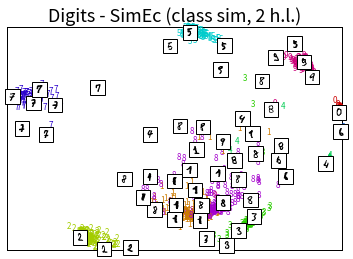

In [12]:
# similarity encoder with similarities relying on class information - 2 hidden layers
e_csimenc = SimilarityEncoder(S.shape[1], X.shape[1], 2, [100, 50], [T.tanh, T.tanh, None, thr_sigmoid], lrate=8., orthOT_reg=0.005)
e_csimenc.fit(X, S, verbose=False)
X_embed = e_csimenc.transform(X)
plot_digits(X_embed, digits, title='Digits - SimEc (class sim, 2 h.l.)')

Using a thresholding function on the output really is key here, without, the clusters are not nearly as nicely separated.

Final training error: 0.0701619063; lowest error: 0.0701619063
Last mean error: 0.0701618079


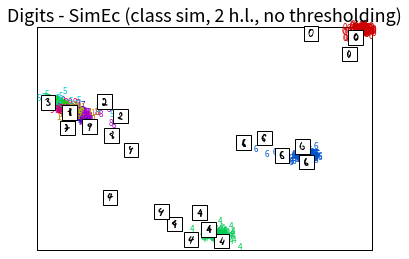

In [13]:
# similarity encoder with similarities relying on class information - no thresholding
e_csimenc = SimilarityEncoder(S.shape[1], X.shape[1], 2, [100, 50], [T.tanh, T.tanh, None, None], lrate=5., orthOT_reg=0.005)
e_csimenc.fit(X, S, verbose=False)
X_embed = e_csimenc.transform(X)
plot_digits(X_embed, digits, title='Digits - SimEc (class sim, 2 h.l., no thresholding)')

#### Unsupervised non-linear similarity functions
Let's try something else to see if SimEcs can really do more than just reproduce linear kPCA and use labels.

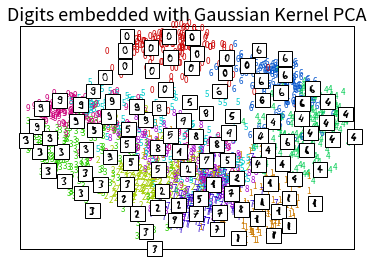

In [14]:
# Gaussian kernel PCA solution
D = squareform(pdist(X, 'euclidean'))
gamma = 1./(np.median(D)**2)    
e_gkpca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
X_embed = e_gkpca.fit_transform(X)
plot_digits(X_embed, digits, title='Digits embedded with Gaussian Kernel PCA')

Ok, this looks too much like the linear kPCA solution. How about isomap.

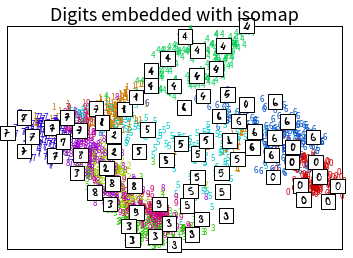

In [15]:
# isomap
e_isomap = Isomap(n_neighbors=10, n_components=2)
X_embed = e_isomap.fit_transform(X)
plot_digits(X_embed, digits, title='Digits embedded with isomap')

For the corresponding similarity encoder we include two additional hidden layers with a non-linear activation function.

Final training error: 0.0128795445; lowest error: 0.0128795445
Last mean error: 0.0128791553


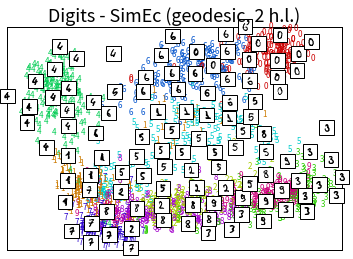

In [16]:
# similarity encoder based on isomap
K_geod = e_isomap.dist_matrix_
e_gsimenc = SimilarityEncoder(K_geod.shape[1], X.shape[1], 2, [100, 20], [T.nnet.relu, T.nnet.relu, None, None], lrate=2., orthOT_reg=0.02)
e_gsimenc.fit(X, center_K(K_geod), verbose=False)
X_embed = e_gsimenc.transform(X)
plot_digits(X_embed, digits, title='Digits - SimEc (geodesic, 2 h.l.)')

### MNIST Dataset
Embedding the regular 28x28 pixel MNIST digits

In [36]:
# load digits
mnist = fetch_mldata('MNIST original', data_home='data')
X = mnist.data/255.  # normalize to 0-1
y = np.array(mnist.target, dtype=int)
# subsample 10000 random data points
np.random.seed(42)
n_samples = 10000
n_test = 2000
rnd_idx = np.random.permutation(X.shape[0])[:n_samples]
X_test, y_test = X[rnd_idx[:n_test],:], y[rnd_idx[:n_test]]
X, y = X[rnd_idx[n_test:],:], y[rnd_idx[n_test:]]
n_train, n_features = X.shape

#### Linear SimEc
Linear SimEc again gives the same solution as PCA/linear kPCA.

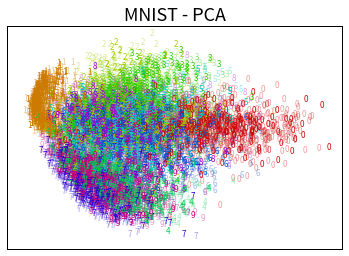

In [18]:
# PCA
e_pca = PCA(n_components=2)
X_embed = e_pca.fit_transform(X)
X_embed_test = e_pca.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - PCA')

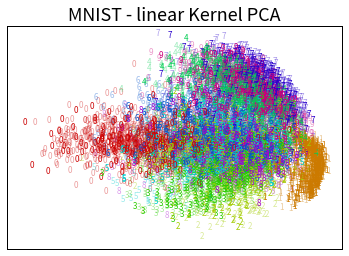

In [19]:
# linear kPCA - same as regular PCA...;)
e_lkpca = KernelPCA(n_components=2, kernel='linear')
X_embed = e_lkpca.fit_transform(X)
X_embed_test = e_lkpca.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - linear Kernel PCA')

Final training error: 0.0034702930; lowest error: 0.0034702930
Last mean error: 0.0034702195


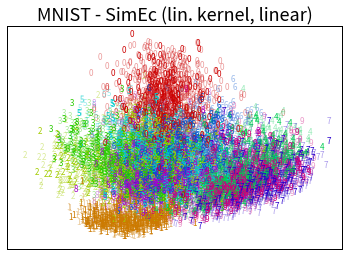

In [20]:
# linear similarity encoder (center the kernel matrix first!)
K_lin = np.dot(X, X.T)
e_lsimenc = SimilarityEncoder(K_lin.shape[1], X.shape[1], e_dim=2, lrate=1.)
e_lsimenc.fit(X, center_K(K_lin), verbose=False)
X_embed = e_lsimenc.transform(X)
X_embed_test = e_lsimenc.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - SimEc (lin. kernel, linear)')

#### Non-linear SimEc
kPCA with an rbf kernel looks very similar to linear kPCA. And we get a similar solution with a non-linear SimEc as well (again, up to rotation and scaling).

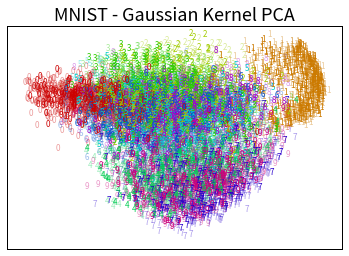

In [21]:
# Gaussian kPCA
D = squareform(pdist(X, 'euclidean'))
gamma = 1./(np.median(D)**2)
e_gkpca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
X_embed = e_gkpca.fit_transform(X)
X_embed_test = e_gkpca.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - Gaussian Kernel PCA')

Final training error: 0.0030477758; lowest error: 0.0030477758
Last mean error: 0.0030477388


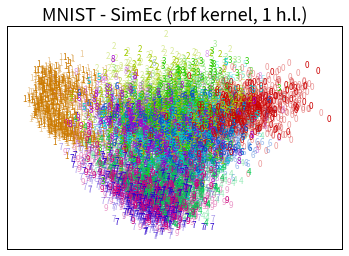

In [22]:
# non-linear SimEc with rbf kernel
K_rbf = rbf_kernel(X, X, gamma)
e_csimenc = SimilarityEncoder(K_rbf.shape[1], X.shape[1], 2, [100], [T.nnet.relu, None, None], lrate=0.5, orthOT_reg=0.1)
e_csimenc.fit(X, center_K(K_rbf), verbose=False)
X_embed = e_csimenc.transform(X)
X_embed_test = e_csimenc.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - SimEc (rbf kernel, 1 h.l.)')

Lets try isomap and the corresponding SimEc here as well.

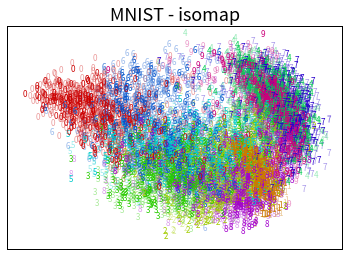

In [23]:
# isomap
e_isomap = Isomap(n_neighbors=30, n_components=2)
X_embed = e_isomap.fit_transform(X)
X_embed_test = e_isomap.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - isomap')

Final training error: 0.0078024738; lowest error: 0.0078024738
Last mean error: 0.0078023103


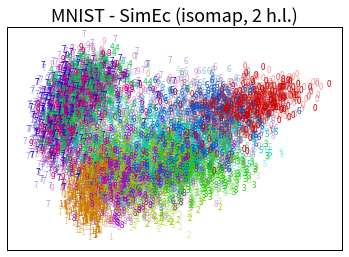

In [24]:
# non-linear SimEc to approximate isomap solution
K_geod = e_isomap.dist_matrix_
e_gsimenc = SimilarityEncoder(K_geod.shape[1], X.shape[1], 2, [100, 20], [T.nnet.relu, T.nnet.relu, None, None], lrate=2., orthOT_reg=0.02)
e_gsimenc.fit(X, center_K(K_geod), verbose=False)
X_embed = e_gsimenc.transform(X)
X_embed_test = e_gsimenc.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - SimEc (isomap, 2 h.l.)')

#### Supervised SimEc
Try SimEcs with a varying number of non-linear hidden layers to approximate class-based similarities in the embedding.

Final training error: 0.0659736487; lowest error: 0.0659736487
Last mean error: 0.0659715212


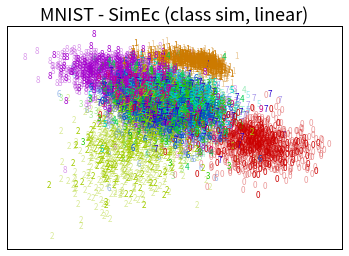

In [25]:
# similarity encoder with similarities relying on class information - linear
Y = np.tile(y, (len(y), 1))
S = np.array(Y==Y.T, dtype=int)
# no centering of S but instead a thresholding in the last layer to transform the output to be between 0 and 1
e_csimenc = SimilarityEncoder(S.shape[1], X.shape[1], 2, [], [None, thr_sigmoid], lrate=0.5, orthOT_reg=0.)
e_csimenc.fit(X, S, verbose=False)
X_embed = e_csimenc.transform(X)
X_embed_test = e_csimenc.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - SimEc (class sim, linear)')

Final training error: 0.0469070712; lowest error: 0.0469070712
Last mean error: 0.0469048760


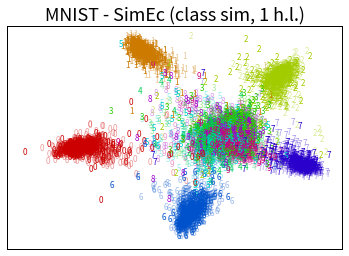

In [26]:
# class labels - 1 hidden layer
e_csimenc = SimilarityEncoder(S.shape[1], X.shape[1], 2, [100], [T.tanh, None, thr_sigmoid], lrate=0.5, orthOT_reg=0.)
e_csimenc.fit(X, S, verbose=False)
X_embed = e_csimenc.transform(X)
X_embed_test = e_csimenc.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - SimEc (class sim, 1 h.l.)')

Final training error: 0.0413584841; lowest error: 0.0413584841
Last mean error: 0.0413551019


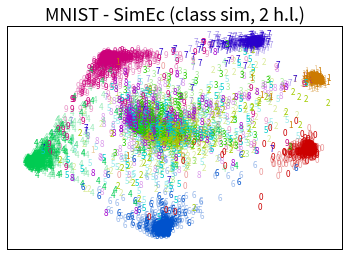

In [27]:
# class labels - 2 hidden layers
e_csimenc = SimilarityEncoder(S.shape[1], X.shape[1], 2, [100, 50], [T.tanh, T.tanh, None, thr_sigmoid], lrate=0.5, orthOT_reg=0.)
e_csimenc.fit(X, S, verbose=False)
X_embed = e_csimenc.transform(X)
X_embed_test = e_csimenc.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - SimEc (class sim, 2 h.l.)')

Final training error: 0.0229524250; lowest error: 0.0228278919
Last mean error: 0.0227298805


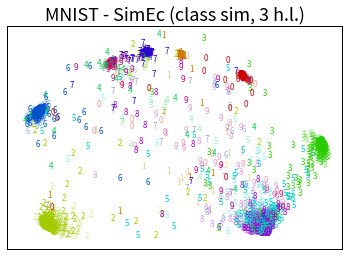

In [37]:
# class labels - 3 hidden layers
e_csimenc = SimilarityEncoder(S.shape[1], X.shape[1], 2, [100, 50, 30], [T.tanh, T.tanh, T.tanh, None, thr_sigmoid], lrate=0.5, lrate_decay=0.995, orthOT_reg=0.)
e_csimenc.fit(X, S, verbose=False, max_epochs=8500)
X_embed = e_csimenc.transform(X)
X_embed_test = e_csimenc.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - SimEc (class sim, 3 h.l.)')

### 20 Newsgroups
Embeddings with similarity encoders can not only be found for image data but also for text documents (which are transformed into high dimensional sparse tf-idf vectors). We subsample 7 of the 20 categories and remove meta information such as headers to avoid overfitting (see also `http://scikit-learn.org/stable/datasets/twenty_newsgroups.html`).

In [31]:
## load the data and transform it into a tf-idf representation
categories = [
    "comp.graphics",
    "rec.autos",
    "rec.sport.baseball",
    "sci.med",
    "sci.space",
    "soc.religion.christian",
    "talk.politics.guns"
]
newsgroups_train = fetch_20newsgroups(subset='train', remove=(
    'headers', 'footers', 'quotes'), data_home='data', categories=categories, random_state=42)
newsgroups_test = fetch_20newsgroups(subset='test', remove=(
    'headers', 'footers', 'quotes'), data_home='data', categories=categories, random_state=42)
# store in dicts
textdict = {i: t for i, t in enumerate(newsgroups_train.data)}
textdict.update({i: t for i, t in enumerate(newsgroups_test.data, len(newsgroups_train.data))})
train_ids = range(len(newsgroups_train.data))
test_ids = range(len(newsgroups_train.data), len(textdict))
print "%i training and %i test samples" % (len(train_ids), len(test_ids))
# transform into tf-idf features
ft = FeatureTransform(norm='max', weight=True, renorm='max')
docfeats = ft.texts2features(textdict, fit_ids=train_ids)
# organize in feature matrix
X, featurenames = features2mat(docfeats, train_ids)
X_test, _ = features2mat(docfeats, test_ids, featurenames)
print "%i features" % len(featurenames)
y, y_test, target_names = newsgroups_train.target, newsgroups_test.target, newsgroups_train.target_names

4107 training and 2734 test samples
45819 features


#### Linear SimEc
Again, linear kPCA and SimEc give the same solution (up to a rotation).

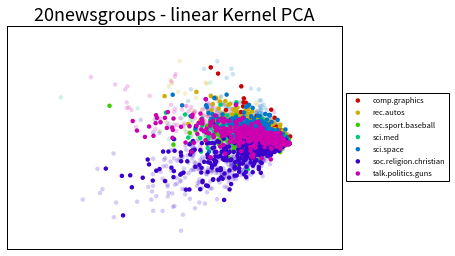

In [32]:
# linear kPCA
e_lkpca = KernelPCA(n_components=2, kernel='linear')
X_embed = e_lkpca.fit_transform(X)
X_embed_test = e_lkpca.transform(X_test)
plot_20news(X_embed, y, target_names, X_embed_test, y_test, title='20newsgroups - linear Kernel PCA', legend=True)

Final training error: 0.0000171737; lowest error: 0.0000171737
Last mean error: 0.0000171702


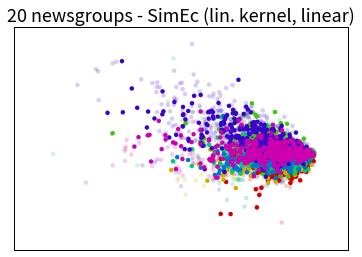

In [33]:
# compute linear kernel and center
K = X.dot(X.T).A
K_cent = center_K(K)
# project to 2d with linear similarity encoder
e_lsimenc = SimilarityEncoder(K_cent.shape[1], X.shape[1], 2, [], [None, None], sparse_features=True, lrate=100., lrate_decay=0.95, orthOT_reg=0.00025)
e_lsimenc.fit(X, K_cent, verbose=False)
X_embed = e_lsimenc.transform(X)
X_embed_test = e_lsimenc.transform(X_test)
plot_20news(X_embed, y, target_names, X_embed_test, y_test,
            title='20 newsgroups - SimEc (lin. kernel, linear)')

#### Supervised SimEc
Non-linear SimEc to create a 2d embedding in which the class-based similarities are retained. (Btw, the thresholding sigmoid also works well as an activation function for earlier hidden layers.)

Final training error: 0.0209640349; lowest error: 0.0184949789
Last mean error: 0.0185860097


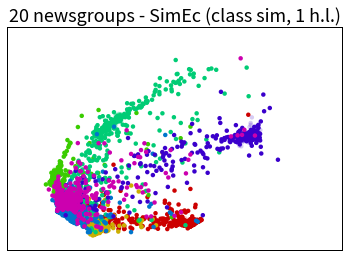

In [34]:
# compute label based simmat
Y = np.tile(y, (len(y), 1))
S = np.array(Y==Y.T, dtype=int)
# project to 2d with similarity encoder
e_lsimenc = SimilarityEncoder(S.shape[1], X.shape[1], 2, [100], [thr_sigmoid, None, thr_sigmoid], sparse_features=True, lrate=6., lrate_decay=0.995, min_lrate=0.00005, orthOT_reg=0.)
e_lsimenc.fit(X, S, verbose=False, max_epochs=3000)
X_embed = e_lsimenc.transform(X)
X_embed_test = e_lsimenc.transform(X_test)
plot_20news(X_embed, y, target_names, X_embed_test, y_test,
            title='20 newsgroups - SimEc (class sim, 1 h.l.)')